# High Frequency Trading Algorithm

You have been tasked by the investment firm Renaissance High Frequency Trading (RHFT) to develop an automated trading strategy utilizing a combination of machine learning algorithms and high frequency algorithms. RHFT wants this new algorithm to be based on stock market data of the 30 stocks in the Dow Jones at the minute level and to conduct buys and sells every minute based on 1 min, 5 min, and 10 min Momentum. The CIO asked you to choose the Machine Learning Algorithm best suited for this task and wants you to execute the trades via Alpaca's API.

### Initial Set-Up

In [1]:
import os
from pathlib import Path
import alpaca_trade_api as tradeapi
import pandas as pd
import numpy as np
import datetime
import time
from dotenv import load_dotenv
import matplotlib.pyplot as plt


In [2]:
# Load .env enviroment variables
load_dotenv('../.env')

True

In [3]:
# Set Alpaca API key and secret
API_KEY = os.getenv('ALPACA_API_KEY')
API_SECRET = os.getenv('ALPACA_SECRET_KEY')


In [4]:
# Create the Alpaca API object, specifying use of the paper trading account:
ALPACA_API_BASE_URL = "https://paper-api.alpaca.markets"
# Create a connection to the API 
api = tradeapi.REST(API_KEY, API_SECRET, ALPACA_API_BASE_URL, api_version="v2")

## Part 2: Train and Compare Multiple Machine Learning Algorithms

 In this section, you'll train each of the requested algorithms and compare performance. Be sure to use the same parameters and training steps for each model. This is necessary to compare each model accurately.

### Preprocessing Data

#### 1. Generate your feature data (`X`) and target data (`y`):
* Create a dataframe `X` that contains all the columns from the returns dataframe that will be used to predict `F_1_m_returns`.
* Create a variable, called `y`, that is equal 1 if `F_1_m_returns` is larger than 0. This will be our target variable.

In [5]:
# Load the dataset returns.csv and set the index to level_0 and time
df_returns = pd.read_csv('returns.csv', index_col=['level_0','level_1'])
df_returns.head()

F_1_m_returns  1_m_returns  5_m_returns  \
level_0 level_1                                                              
FB      2021-01-05 09:40:00-05:00       0.000814     0.000074     0.001260   
        2021-01-05 09:41:00-05:00       0.000887     0.000814     0.001889   
        2021-01-05 09:42:00-05:00       0.000628     0.000887     0.001999   
        2021-01-05 09:43:00-05:00       0.000480     0.000628     0.003408   
        2021-01-05 09:44:00-05:00      -0.001291     0.000480     0.002886   

                                   10_m_returns  
level_0 level_1                                  
FB      2021-01-05 09:40:00-05:00      0.004758  
        2021-01-05 09:41:00-05:00      0.004941  
        2021-01-05 09:42:00-05:00      0.003782  
        2021-01-05 09:43:00-05:00      0.007850  
        2021-01-05 09:44:00-05:00      0.005416

In [6]:
# Create a separate dataframe for features and define the target variable as a binary target
target_col = 'F_1_m_returns'
X = df_returns.drop(columns=target_col)

# Create the target variable
y = np.where(df_returns[target_col] > 0, 1, 0)


##### Note:
> Notice that we don't use shuffle when splitting the dataset into a training and testing dataset. 

> We want to keep the original ordering of the data, so we don't end up using observations in the future to predict past observations,

> This is a critical mistake known as look ahead bias.

#### 2. Use the train_test_split library to split the dataset into a training and testing dataset, with 70% used for testing
* Set the shuffle parameter to False, so that you use the first 70% for training to prvent look ahead bias.
* Make sure you have these 4 variables: `X_train`, `X_test`, `y_train`, `y_test`. 

In [7]:
# Import train_test_split 
from sklearn.model_selection import train_test_split

# Split the dataset without shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
print(X.index.droplevel(1).unique())
print(X_test.index.droplevel(1).unique())
print("This train_test_split doesn't split properly")


Index(['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL', 'MSFT', 'TSLA'], dtype='object', name='level_0')
Index(['GOOGL', 'MSFT', 'TSLA'], dtype='object', name='level_0')
This train_test_split doesn't split properly


#### 3. Use the `Counter` function to test the distribution of the data. 
* The result of `Counter({1: 668, 0: 1194})` reveals the data is indeed unbalanced.

In [9]:
# Import the Counter function from the collections library
from collections import Counter

# Use Counter to count the number 1s and 0 in y_train
Counter(y_train)
# Counter({1: 668, 0: 1194})


Counter({1: 668, 0: 1194})

#### 4. Balance the dataset with the Oversampler libary, setting `random state= 1`.

In [10]:
# Import RandomOverSampler from the imblearn library
from imblearn.over_sampling import RandomOverSampler

# Use RandomOverSampler to resample the datase using random_state=1
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

#### 5. Test the distribution once again with `Counter`. The new result of `Counter({1: 1194, 0: 1194})` shows the data is now balanced.

In [11]:
# Use Counter again to verify imbalance removed
Counter(y_resampled)
# Counter({1: 1194, 0: 1194})


Counter({1: 1194, 0: 1194})

# Machine Learning

#### 1. The first cells in this section provide an example of how to fit and train your model using the `LogisticRegression` model from sklearn:
* Import select model.
* Instantiate model object.
* Fit the model to the resampled data - `X_resampled` and `y_resampled`.
* Predict the model using `X_test`.
* Print the classification report.

In [12]:
# Import classification_report from sklearn
from sklearn.metrics import classification_report

              precision    recall  f1-score   support

           0     0.5365    0.5259    0.5312       405
           1     0.5212    0.5318    0.5264       393

    accuracy                         0.5288       798
   macro avg     0.5289    0.5289    0.5288       798
weighted avg     0.5290    0.5288    0.5288       798

The cumulative returns are incorrect. They should be cumulatively multiplied for each stock and the returns of each stock summed up for the total returns.


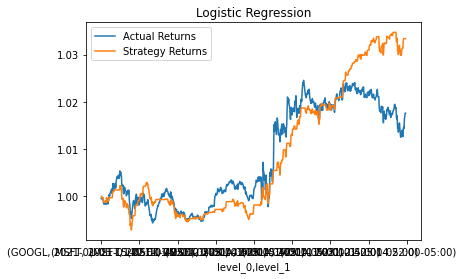

In [13]:
# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

# Create a LogisticRegression model and train it on the X_resampled data we created before
log_model = LogisticRegression()
log_model.fit(X_resampled, y_resampled)  

# Use the model you trained to predict using X_test
y_pred = log_model.predict(X_test)

# Print out a classification report toevaluate performance
print(classification_report(y_test, y_pred, digits=4))

# Create a predictions DataFrame
pred_df = pd.DataFrame(index=X_test.index)

# Add the model predictions to the DataFrame
pred_df['Predicted'] = y_pred

# Add the actual returns to the DataFrame
pred_df['Actual Returns'] = df_returns[target_col]

# Add the strategy returns to the DataFrame
pred_df['Strategy Returns'] = pred_df['Actual Returns'] * pred_df['Predicted'].shift()

cum_df = (1 + pred_df[['Actual Returns', 'Strategy Returns']]).cumprod()
title = "Logistic Regression"
fig = cum_df.plot(title=title).get_figure()
# # Save plot as image
# fig.savefig(f"../Images/{title}.png", bbox_inches='tight')
print("The cumulative returns are incorrect. They should be cumulatively multiplied for each stock and the returns of each stock summed up for the total returns.")


In [14]:
pred_df_dict = {s:d.droplevel('level_0', axis='index') for s, d in pred_df.groupby('level_0')}
df_pred_returns = pd.concat(pred_df_dict, axis='columns')
# df_pred_returns.head()
# pred_df.index.droplevel(1).unique()
X.index.droplevel(1).unique()

Index(['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL', 'MSFT', 'TSLA'], dtype='object', name='level_0')

#### 2. Use the same approach as above to train and test the following ML Algorithms:
* [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
* [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
* [XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

#### RandomForestClassifier

In [15]:
# Import RandomForestClassifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier model and train it on the X_resampled data we created before
model_rf = RandomForestClassifier()
model_rf.fit(X_resampled, y_resampled)

# Use the model you trained to predict using X_test
y_pred_rf = model_rf.predict(X_test)

# Print out a classification report to evaluate performance
print(classification_report(y_test, y_pred_rf, digits=4))

#               precision    recall  f1-score   support

#            0     0.5041    0.6049    0.5499       405
#            1     0.4872    0.3868    0.4312       393

#     accuracy                         0.4975       798
#    macro avg     0.4956    0.4959    0.4906       798
# weighted avg     0.4958    0.4975    0.4915       798


              precision    recall  f1-score   support

           0     0.4990    0.6247    0.5548       405
           1     0.4777    0.3537    0.4064       393

    accuracy                         0.4912       798
   macro avg     0.4883    0.4892    0.4806       798
weighted avg     0.4885    0.4912    0.4817       798



#### GradientBoostingClassifier

In [16]:
# Import RandomForestClassifier from sklearn
from sklearn.ensemble import GradientBoostingClassifier

# Create a GradientBoostingClassifier model and train it on the X_resampled data we created before
model_gb = GradientBoostingClassifier()
model_gb.fit(X_resampled, y_resampled)

# Use the model you trained to predict using X_test
y_pred_gb = model_gb.predict(X_test)

# Print out a classification report to evaluate performance
print(classification_report(y_test, y_pred_gb, digits=4))
#               precision    recall  f1-score   support

#            0     0.4976    0.5136    0.5055       405
#            1     0.4816    0.4656    0.4735       393

#     accuracy                         0.4900       798
#    macro avg     0.4896    0.4896    0.4895       798
# weighted avg     0.4897    0.4900    0.4897       798


              precision    recall  f1-score   support

           0     0.4988    0.5136    0.5061       405
           1     0.4829    0.4682    0.4755       393

    accuracy                         0.4912       798
   macro avg     0.4909    0.4909    0.4908       798
weighted avg     0.4910    0.4912    0.4910       798



#### AdaBoostClassifier

In [17]:
# Import RandomForestClassifier from sklearn
from sklearn.ensemble import AdaBoostClassifier

# Create a AdaBoostClassifier model and train it on the X_resampled data we created before
model_ab = AdaBoostClassifier()
model_ab.fit(X_resampled, y_resampled)

# Use the model you trained to predict using X_test
y_pred_ab = model_ab.predict(X_test)

# Print out a classification report to evaluate performance
print(classification_report(y_test, y_pred_ab, digits=4))
#               precision    recall  f1-score   support

#            0     0.4951    0.3753    0.4270       405
#            1     0.4847    0.6056    0.5385       393

#     accuracy                         0.4887       798
#    macro avg     0.4899    0.4905    0.4827       798
# weighted avg     0.4900z    0.4887    0.4819       798

              precision    recall  f1-score   support

           0     0.4951    0.3753    0.4270       405
           1     0.4847    0.6056    0.5385       393

    accuracy                         0.4887       798
   macro avg     0.4899    0.4905    0.4827       798
weighted avg     0.4900    0.4887    0.4819       798



#### XGBClassifier

In [18]:
# Import RandomForestClassifier from sklearn
from xgboost import XGBClassifier

# Create a XGBClassifier model and train it on the X_resampled data we created before
model_xgb = XGBClassifier()
model_xgb.fit(X_resampled, y_resampled)

# Use the model you trained to predict using X_test
y_pred_xgb = model_xgb.predict(X_test)

# Print out a classification report to evaluate performance
print(classification_report(y_test, y_pred_xgb, digits=4))


# C:\Users\lorie\Anaconda3\envs\pyvizenv25\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
#   warnings.warn(label_encoder_deprecation_msg, UserWarning)
# [15:23:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

#               precision    recall  f1-score   support

#            0     0.4901    0.5481    0.5175       405
#            1     0.4696    0.4122    0.4390       393

#     accuracy                         0.4812       798
#    macro avg     0.4798    0.4802    0.4783       798
# weighted avg     0.4800    0.4812    0.4788       798

C:\Users\Vincent\.conda\envs\wk15\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\Vincent\.conda\envs\wk15\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Vincent\.conda\envs\wk15\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int6

[21:55:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0     0.4901    0.5481    0.5175       405
           1     0.4696    0.4122    0.4390       393

    accuracy                         0.4812       798
   macro avg     0.4798    0.4802    0.4783       798
weighted avg     0.4800    0.4812    0.4788       798



### Evaluate the performance of each model


#### 1. Using the classification report for each model, choose the model with the highest precision for use in your algo-trading program.
#### 2. Save the selected model with the `joblib` libary to avoid retraining every time you wish to use it.

In [19]:
# Import the joblib library 
import joblib

# Use the library to save the model that you want to use for trading
joblib.dump(log_model, 'log_model.pkl')

['log_model.pkl']

## Part 3: Implement the strongest model using Apaca API

### Develop the Algorithm


#### 1. Use the provided code to ping the Alpaca API and create the DataFrame needed to feed data into the model.
   * This code will also store the correct feature data in `X` for later use.

In [20]:
# Create the list of tickers

ticker_list = ['FB','AMZN','AAPL','NFLX', 'GOOGL', 'MSFT', 'TSLA']
# Define Dates

beg_date = '2021-01-06'
end_date = '2021-01-06'

# Convert the date in a format the Alpaca API reqires
# start =  pd.Timestamp(f'{beg_date} 09:30:00-0400', tz='America/New_York').replace(hour=9, minute=30, second=0).astimezone('GMT').isoformat()[:-6]+'Z'
# end   =  pd.Timestamp(f'{end_date} 16:00:00-0400', tz='America/New_York').replace(hour=15, minute=0, second=0).astimezone('GMT').isoformat()[:-6]+'Z'
start =  pd.Timestamp(f'{beg_date} 09:30:00', tz='America/New_York').isoformat()
end   =  pd.Timestamp(f'{end_date} 16:00:00', tz='America/New_York').isoformat()
timeframe='1Min'

# Use iloc to get the last 10 mins every time we pull new data
prices = api.get_bars(
    ticker_list,
    "1Min",
    start=start,
    end=end,
    limit=None,
).df

prices.ffill(inplace=True)
symbol_df_dict = {symbol: sub_df for symbol, sub_df in prices.groupby('symbol')}
df_prices = pd.concat(symbol_df_dict, axis='columns')
# Create an empty DataFrame for closing prices

# Fetch the closing prices of our tickers
df_closing_prices = df_prices[pd.MultiIndex.from_product([symbol_df_dict.keys(), ['close']])].droplevel(1, axis='columns').iloc[-11:]
# df_closing_prices = df_prices[pd.MultiIndex.from_product([symbol_df_dict.keys(), ['open','high','low','close']])]

# print(df_closing_prices.loc['2021-01-06 14:50:00-05:00':'2021-01-06 15:00:00-05:00'])
print(df_closing_prices)

#                                 FB      AMZN     AAPL    NFLX    GOOGL  \
# time                                                                     
# 2021-01-06 14:50:00-05:00  264.610  3146.960  127.110  506.54  1721.82   
# 2021-01-06 14:51:00-05:00  264.630  3146.910  127.430  506.54  1721.82   
# 2021-01-06 14:52:00-05:00  264.830  3147.980  127.720  506.69  1723.67   
# 2021-01-06 14:53:00-05:00  264.525  3148.570  127.510  506.01  1723.67   
# 2021-01-06 14:54:00-05:00  264.560  3147.840  127.645  506.01  1720.84   
# 2021-01-06 14:55:00-05:00  264.880  3150.330  127.920  506.30  1720.60   
# 2021-01-06 14:56:00-05:00  264.965  3150.610  128.150  506.72  1721.10   
# 2021-01-06 14:57:00-05:00  264.980  3151.745  127.980  507.07  1720.07   
# 2021-01-06 14:58:00-05:00  265.000  3149.280  127.850  506.33  1720.07   
# 2021-01-06 14:59:00-05:00  265.360  3150.840  127.930  506.13  1720.48   
# 2021-01-06 15:00:00-05:00  264.840  3148.580  127.630  506.43  1720.48   

#                               MSFT    TSLA  
# time                                        
# 2021-01-06 14:50:00-05:00  213.930  753.33  
# 2021-01-06 14:51:00-05:00  214.080  757.44  
# 2021-01-06 14:52:00-05:00  214.220  759.03  
# 2021-01-06 14:53:00-05:00  213.960  756.65  
# 2021-01-06 14:54:00-05:00  214.230  759.90  
# 2021-01-06 14:55:00-05:00  214.330  762.45  
# 2021-01-06 14:56:00-05:00  214.380  763.04  
# 2021-01-06 14:57:00-05:00  214.210  763.04  
# 2021-01-06 14:58:00-05:00  214.180  762.30  
# 2021-01-06 14:59:00-05:00  214.235  761.80  
# 2021-01-06 15:00:00-05:00  214.070  761.24

                               AAPL       AMZN        FB     GOOGL      MSFT  \
timestamp                                                                      
2021-01-06 20:50:00+00:00  127.0200  3140.9000  263.5300  1721.630  212.6501   
2021-01-06 20:51:00+00:00  126.8300  3136.1533  263.2600  1721.205  212.3950   
2021-01-06 20:52:00+00:00  126.5916  3134.7493  263.1100  1721.930  212.1600   
2021-01-06 20:53:00+00:00  126.7200  3135.0300  263.4625  1722.860  212.2818   
2021-01-06 20:54:00+00:00  126.8300  3139.9400  263.9950  1724.340  212.4200   
2021-01-06 20:55:00+00:00  126.5900  3137.0700  263.5100  1723.480  212.1850   
2021-01-06 20:56:00+00:00  126.4900  3135.2950  263.3700  1723.340  212.1300   
2021-01-06 20:57:00+00:00  126.7650  3138.4800  263.4500  1725.020  212.3229   
2021-01-06 20:58:00+00:00  126.6199  3136.1300  263.3500  1724.630  212.2150   
2021-01-06 20:59:00+00:00  126.6200  3138.0100  263.3050  1723.380  212.2200   
2021-01-06 21:00:00+00:00  126.4000  313

In [21]:
# Create list of momentums
list_of_momentums = [1,5,10]

for i in list_of_momentums:  
    # Compute percentage change for each one of the momentums in the momentum list
    returns_temp = df_closing_prices.pct_change(i)
    # Unstack the returns 
    returns_temp = pd.DataFrame(returns_temp.unstack())
    name = f'{i}_m_returns'
    returns_temp.rename(columns={0: name}, inplace = True)
    # Reset the index so we can merge based on index
    returns_temp.reset_index(inplace = True)
    # Merge newly computed returns with previously created returns
    if i ==1:
        returns = returns_temp
    else:
        returns = pd.merge(returns,returns_temp,left_on=['level_0', 'timestamp'],right_on=['level_0', 'timestamp'], how='left', suffixes=('_original', 'right'))

# Drop nulls and set index
returns.dropna(axis=0, how='any', inplace=True)
returns.set_index(['level_0', 'timestamp'], inplace=True)

# Generate feature data and preview first 10 rows.
X = returns
X.head(10)


# 		1_m_returns	5_m_returns	10_m_returns
# level_0	time			
# FB	2021-01-06 15:00:00-05:00	-0.001960	-0.000151	0.000869
# AMZN	2021-01-06 15:00:00-05:00	-0.000717	-0.000555	0.000515
# AAPL	2021-01-06 15:00:00-05:00	-0.002345	-0.002267	0.004091
# NFLX	2021-01-06 15:00:00-05:00	0.000593	0.000257	-0.000217
# GOOGL	2021-01-06 15:00:00-05:00	0.000000	-0.000070	-0.000778
# MSFT	2021-01-06 15:00:00-05:00	-0.000770	-0.001213	0.000654
# TSLA	2021-01-06 15:00:00-05:00	-0.000735	-0.001587	0.010500

,,1_m_returns,5_m_returns,10_m_returns
level_0,timestamp,,,
AAPL,2021-01-06 21:00:00+00:00,-0.001737,-0.001501,-0.004881
AMZN,2021-01-06 21:00:00+00:00,0.000118,0.000418,-0.000802
FB,2021-01-06 21:00:00+00:00,0.000019,-0.000759,-0.000835
GOOGL,2021-01-06 21:00:00+00:00,-0.000290,-0.000348,0.000726
MSFT,2021-01-06 21:00:00+00:00,-0.000188,-0.000024,-0.002211
NFLX,2021-01-06 21:00:00+00:00,-0.001379,-0.005851,-0.007589
TSLA,2021-01-06 21:00:00+00:00,-0.001256,0.000586,-0.002746


#### 2. Using `joblib`, load the chosen model.

In [22]:
# Load the previously trained and saved model using joblib
model = joblib.load('log_model.pkl')

#### 3. Use the model file to make predicttions:
* Use `predict` on `X` and save this as `y_pred`.
* Convert `y_pred` to a DataFrame, setting the index to the index of `X`.
* Rename the column 0 to 'buy', be sure to set `inplace =True`.

In [23]:
# Use the model file to predict on X
y_pred = model.predict(X)

# Convert y_pred to a dataframe, set the index to the index of X
pred_df = pd.DataFrame(index=X.index)

# Rename the column 0 to 'buy', be sure to set inplace =True
pred_df['buy'] = y_pred
pred_df

#                                   buy
# level_0	time
# FB	2021-01-06 15:00:00-05:00	1
# AMZN	2021-01-06 15:00:00-05:00	1
# AAPL	2021-01-06 15:00:00-05:00	1
# NFLX	2021-01-06 15:00:00-05:00	0
# GOOGL	2021-01-06 15:00:00-05:00	1
# MSFT	2021-01-06 15:00:00-05:00	1
# TSLA	2021-01-06 15:00:00-05:00	0

,,buy
level_0,timestamp,
AAPL,2021-01-06 21:00:00+00:00,1
AMZN,2021-01-06 21:00:00+00:00,0
FB,2021-01-06 21:00:00+00:00,1
GOOGL,2021-01-06 21:00:00+00:00,1
MSFT,2021-01-06 21:00:00+00:00,1
NFLX,2021-01-06 21:00:00+00:00,1
TSLA,2021-01-06 21:00:00+00:00,1


#### 4. Filter the stocks where 'buy' is equal to 1, saving the filter as `y_pred`.

In [24]:
# Filter the stocks where 'buy' is equal to 1
stocks_to_buy = pred_df.loc[pred_df["buy"] == 1].index.get_level_values(level=0)

In [25]:
# Filter the stocks where 'buy' is equal to 1
stocks_to_buy = pred_df.loc[y_pred == 1].index.get_level_values(level=0)
stocks_to_buy

Index(['AAPL', 'FB', 'GOOGL', 'MSFT', 'NFLX', 'TSLA'], dtype='object', name='level_0')

#### 5. Using the `y_pred` filter, create a dictionary called `buy_dict` and assign 'n' to each Ticker (key value) as a placeholder.

In [26]:
# Create dictionary from y_pred and assign a 'n' to each of them for now as a placeholder.
buy_dict = dict.fromkeys(stocks_to_buy, 'n')
buy_dict

{'AAPL': 'n', 'FB': 'n', 'GOOGL': 'n', 'MSFT': 'n', 'NFLX': 'n', 'TSLA': 'n'}

#### 6. Obtain the total available equity in your account from the Alpaca API and store in a variable called `total_capital`. You will split the capital equally between all selected stocks per the CIO's request.

In [27]:
# Pull the total available equity in our account from the  Alpaca API
account = api.get_account()
total_capital = float(account.equity)

In [28]:
# Compute capital per stock, divide equity in account by number of stocks
# Use Alpaca API to pull the equity in the account
if len(buy_dict) > 0:
    capital_per_stock = float(total_capital)/ len(buy_dict)
else:
    capital_per_stock = 0
print(f'Capital per stock: {capital_per_stock}')

Capital per stock: 16666.666666666668


#### 7. Use a for-loop to iterate through `buy_dict` to determine the number stocks you need to buy for each ticker.

In [29]:
# Use for loop to iterate through dictionary of buys 
# Determine the number stocks we need to buy for each ticker
for ticker in buy_dict:
    try:
        buy_dict[ticker] = int(capital_per_stock /int(df_closing_prices[ticker].iloc[-1]))
    except:
        pass

print(buy_dict)
# {'FB': 75, 'AMZN': 6, 'AAPL': 156, 'GOOGL': 11, 'MSFT': 92}

{'AAPL': 132, 'FB': 63, 'GOOGL': 9, 'MSFT': 78, 'NFLX': 33, 'TSLA': 22}


#### 8. Cancel all previous orders in the Alpaca API (so you don't buy more than intended) and sell all currently held stocks to close all positions.

In [30]:
# Cancel all previous orders in the Alpaca API
api.cancel_all_orders()

# Sell all currently held stocks to close all positions
api.close_all_positions()

[]

#### 9. Iterate through `buy_dict` and send a buy order for each ticker with their corresponding number of shares.

In [31]:
# Iterate through the longlist object and send a buy order for each ticker with a corresponding number of shares:
for ticker, numShare in buy_dict.items():
    api.submit_order(
        ticker,
        numShare,
        "buy"
    )
    print(f"buying {ticker} numShare {numShare}")
# buying FB numShare 75
# buying AMZN numShare 6
# buying AAPL numShare 156
# buying GOOGL numShare 11
# buying MSFT numShare 92

buying AAPL numShare 132
buying FB numShare 63
buying GOOGL numShare 9
buying MSFT numShare 78
buying NFLX numShare 33
buying TSLA numShare 22


### Automate the algorithm

#### 1. Make a function called `trade()` that incorporates all of the steps above.

In [32]:
# Add all of the steps conducted above into the function trade
def trade():

    ticker_list = ['FB','AMZN','AAPL','NFLX', 'GOOGL', 'MSFT', 'TSLA']

    # Notice that we remove the start and end variables since we want the latest prices.
    prices = api.get_bars(
        ticker_list,
        timeframe='1Min',
    ).df
    # fill blank values
    prices.ffill(inplace=True)
    # slice the df, grouping them by symbol
    symbol_df_dict = {symbol: sub_df for symbol, sub_df in prices.groupby('symbol')}
    # concatenate into a multiindex dataframe
    df_prices = pd.concat(symbol_df_dict, axis='columns')

    # Fetch the closing prices of our tickers and drop a level
    # Use iloc to get the last 10 mins every time we pull new data
    df_closing_prices = df_prices[pd.MultiIndex.from_product([symbol_df_dict.keys(), ['close']])].droplevel(1, axis='columns').iloc[-11:]

    print(df_closing_prices.head())
    
    # Loop through momentums to build new DataFrame
    list_of_momentums = [1,5,10]

    for i in list_of_momentums:  
        # Compute percentage change for each one of the momentums in the momentum list
        returns_temp = df_closing_prices.pct_change(i)
        # Unstack the returns 
        returns_temp = pd.DataFrame(returns_temp.unstack())
        name = f'{i}_m_returns'
        returns_temp.rename(columns={0: name}, inplace = True)
        # Reset the index so we can merge based on index
        returns_temp.reset_index(inplace = True)
        # Merge newly computed returns with previously created returns
        if i ==1:
            returns = returns_temp
        else:
            returns = pd.merge(returns,returns_temp,left_on=['level_0', 'timestamp'],right_on=['level_0', 'timestamp'], how='left', suffixes=('_original', 'right'))

    # Drop nulls and set index
    returns.dropna(axis=0, how='any', inplace=True)
    returns.set_index(['level_0', 'timestamp'], inplace=True)

    # Generate feature data
    X = returns

    # Preprocess data for model
    # Load the previously trained and saved model using joblib
    model = joblib.load('log_model.pkl')
    # Use the model file to predict on X
    y_pred = model.predict(X)

    # Convert y_pred to a dataframe, set the index to the index of X
    pred_df = pd.DataFrame(index=X.index)

    # Rename the column 0 to 'buy', be sure to set inplace =True
    pred_df['buy'] = y_pred
    # Filter the stocks where 'buy' is equal to 1
    stocks_to_buy = pred_df.loc[pred_df["buy"] == 1].index.get_level_values(level=0)

    # Create the `buy_dict` object
    buy_dict = dict.fromkeys(stocks_to_buy, 'n')
    
    # Split capital between stocks and determine buy or sell
    # Pull the total available equity in our account from the  Alpaca API
    account = api.get_account()
    total_capital = float(account.equity)
    # Compute capital per stock, divide equity in account by number of stocks
    # Use Alpaca API to pull the equity in the account
    if len(buy_dict) > 0:
        capital_per_stock = float(total_capital)/ len(buy_dict)
    else:
        capital_per_stock = 0
    print(f'Capital per stock: {capital_per_stock}')
    # Use for loop to iterate through dictionary of buys 
    # Determine the number stocks we need to buy for each ticker
    for ticker in buy_dict:
        try:
            buy_dict[ticker] = int(capital_per_stock /int(df_closing_prices[ticker].iloc[-1]))
        except:
            pass
    
    # Cancel pending orders and close positions
    api.cancel_all_orders()
    api.close_all_positions()

    # Submit orders
    for ticker, numShare in buy_dict.items():
        api.submit_order(
            ticker,
            numShare,
            "buy"
        )
        print(f"buying {ticker} numShare {numShare}")


#### 2. Import Python's schedule module.

In [33]:
# Import Python's schedule module 
import schedule

#### 3. Use the "schedule" module to automate the algorithm:
* Clear the schedule with `.clear()`.
* Define a schedule to run the trade function every minute at 5 seconds past the minute mark (e.g. `10:31:05`).
* Use the Alpaca API to check whether the market is open.
* Use run_pending() function inside schedule to execute the schedule you defined while the market is open

In [34]:
# Clear the schedule
schedule.clear()

# Define a schedule to run the trade function every minute at 5 seconds past the minute mark (e.g. 10:31:05)
schedule.every().minute.at(":05").do(trade)

# Use the Alpaca API to check whether the market is open
clock = api.get_clock()

# Use run_pending() function inside schedule to execute the schedule you defined as long as the market is open
while clock.is_open:
    closingTime = clock.next_close.replace(tzinfo=datetime.timezone.utc).timestamp()
    currTime = clock.timestamp.replace(tzinfo=datetime.timezone.utc).timestamp()
    timeToClose = closingTime - currTime

    if timeToClose < 60:
        # Close all positions when 1 minutes til market close.
        print("Market closing soon. Stop trading.")
        # Cancel pending orders and close positions
        api.cancel_all_orders()
        api.close_all_positions()
        break
    schedule.run_pending()
    time.sleep(1)
print(f"Market closed, next open market day will be {clock.next_open.astimezone('Australia/Sydney')}")

#                                FB     AMZN     AAPL     NFLX    GOOGL  \
# time                                                                    
# 2021-02-02 15:13:00-05:00  267.24  3401.17  134.705  552.420  1924.72   
# 2021-02-02 15:14:00-05:00  267.42  3397.59  134.665  552.530  1924.84   
# 2021-02-02 15:15:00-05:00  267.30  3395.85  134.700  552.690  1924.96   
# 2021-02-02 15:16:00-05:00  267.11  3393.24  134.730  552.320  1925.13   
# 2021-02-02 15:17:00-05:00  267.19  3397.00  134.820  552.685  1926.48   

#                               MSFT    TSLA  
# time                                        
# 2021-02-02 15:13:00-05:00  240.705  878.60  
# 2021-02-02 15:14:00-05:00  240.590  878.05  
# 2021-02-02 15:15:00-05:00  240.640  878.22  
# 2021-02-02 15:16:00-05:00  240.460  878.75  
# 2021-02-02 15:17:00-05:00  240.670  878.75  
# buying AAPL numShare 371
# buying TSLA numShare 56
#                                FB      AMZN     AAPL     NFLX    GOOGL  \
# time                                                                     
# 2021-02-02 15:14:00-05:00  267.42  3397.590  134.665  552.530  1924.84   
# 2021-02-02 15:15:00-05:00  267.30  3395.850  134.700  552.690  1924.96   
# 2021-02-02 15:16:00-05:00  267.11  3393.240  134.730  552.320  1925.13   
# 2021-02-02 15:17:00-05:00  267.19  3397.000  134.820  552.685  1926.48   
# 2021-02-02 15:18:00-05:00  267.21  3398.505  134.760  552.340  1926.37   

#                              MSFT    TSLA  
# time                                       
# 2021-02-02 15:14:00-05:00  240.59  878.05  
# 2021-02-02 15:15:00-05:00  240.64  878.22  
# 2021-02-02 15:16:00-05:00  240.46  878.75  
# 2021-02-02 15:17:00-05:00  240.67  878.75  
# 2021-02-02 15:18:00-05:00  240.72  878.39  
# buying AMZN numShare 5
# buying AAPL numShare 148
# buying NFLX numShare 35
# buying GOOGL numShare 10
# buying TSLA numShare 22


Market closed, next open market day will be 2022-03-22 00:30:00+11:00
